In [7]:
import pandas as pd
from math import log
import graphviz
%run Datasets.ipynb

Like many things that people do, the field of machine learning has cycles of fashion.  Ideas and algorithms rise and fall in popularity, with some making repeated appearances through time.  Decision trees had their heyday in the 1990's, with innumerable papers appearing in machine learning conferences exploring applications and algorithmic enhancements.  Though they eventually gave way to the next hot topic, decision trees remain a workhorse algorithm.  There are many reasons for that.  
* It's easy for people to understand decision trees, both the representation and the learning algorithm.  That is often crucial in real-world applications where domain experts are reluctant to trust models that are essentially black boxes.
* A decision tree variant known as a random forest (yes, it's a collection of trees) is remarkably powerful.  In many brainstorming sessions about difficult real-world classification problems, at some point someone invariably asks "have you tried a random forest?" and everyone else says "yeah, you should try a random forest."
* Decision trees work well with both numeric and discrete feature values, and solve binary and multi-class problems in the same framework.  In contrast, the Perceptron requires all features to be numeric to compute dot products, and the binary and multi-class Perceptron are similar but not the same.
* Decision trees make explicit choices about which features to use.  They can, and often do, leave features out of the final model.  That makes them robust against irrelevant features, like the day of the week on which I picked a mushroom when trying to predict whether the mushroom is poisonous or edible.

This chapter explores decision trees: what are they and how are they learned from data?  Along the way we'll touch on some fundamental issues in machine learning.  For example, the Perceptron runs until it perfectly classifies the training data (or hits the limit on the number of epochs).  It is often the case, perhaps counterintuitively at first, that maximizing accuracy on the training data can hurt generalization, or the ability to accurately classify new data.  Decision trees are particularly good for exploring that issue.

We'll make extensive use of the LED dataset in this chapter.<sup>1</sup>  That dataset has ten classes, one for each of the digits from 0 to 9, and seven features, one for each segment in a standard LED display like the one on your alarm clock.  The cell below shows a visual representation of an instance of each class when there is no noise in the features.  Later in this chapter we'll add feature noise by randomly flipping the state of segments (from off to on and from on to off) to make the learning problem more difficult.  We'll also add irrelevant features that carry no information about the class label to see what impact they have.

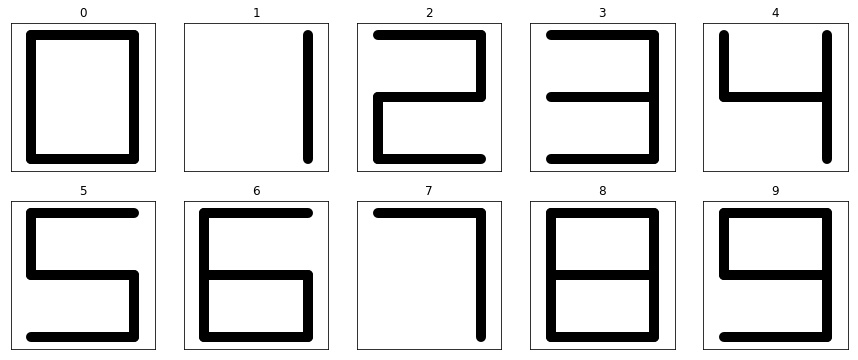

In [8]:
D = led_dataset(samples = 1, noise = 0.0)
plot_led(D, cols = 5)

The cell below shows the feature-based representation of the same data.  The seven segments are named as follows.  There are three horizontal segments - ${\tt top}$, ${\tt middle}$, and ${\tt bottom}$.  There are two vertical segments on the left side (${\tt top\_left}$ and ${\tt bottom\_left}$) and two vertical segments on the right side (${\tt top\_right}$ and ${\tt bottom\_right}$).  A segment is visible if it's value is ${\tt on}$ and is not visible if it's value is ${\tt off}$.  A noise-free class ${\tt 1}$ instance has ${\tt top\_right} = {\tt on}$ and  ${\tt bottom\_right} ={\tt on}$, with all other features having value ${\tt off}$.  A noise-free class ${\tt 4}$ instance is like a class ${\tt 1}$ instance except it also has ${\tt top\_left} = {\tt on}$ and ${\tt middle} = {\tt on}$.

In [9]:
D

,bottom,bottom_left,bottom_right,middle,top,top_left,top_right,y
0,on,on,on,off,on,on,on,0
1,off,off,on,off,off,off,on,1
2,on,on,off,on,on,off,on,2
3,on,off,on,on,on,off,on,3
4,off,off,on,on,off,on,on,4
5,on,off,on,on,on,on,off,5
6,on,on,on,on,on,on,off,6
7,off,off,on,off,on,off,on,7
8,on,on,on,on,on,on,on,8
9,on,off,on,on,on,on,on,9


## 3.1 Representation

Consider the task of using the LED features to discrimminate only among classes ${\tt 2}$, ${\tt 3}$, and ${\tt 4}$.  How would you do it?  Looking at the cell below, it's clear that class ${\tt 4}$ is the only one for which ${\tt upper\_left} = {\tt on}$.  A rule is a natural way to express that idea:

``
if upper_left == on then
  y = 4
``

Observing the value of a single feature is enough to determine that the instance belongs to class ${\tt 4}$ and not class ${\tt 2}$ or class ${\tt 3}$.  But what if ${\tt upper\_left} = {\tt off}$?  In that case the instance is either a ${\tt 2}$ or a ${\tt 3}$.  Between the ${\tt 2}$ and the ${\tt 3}$, the ${\tt 2}$ is the only one for which ${\tt bottom\_right} = {\tt off}$.  Let's modify the rule above to capture that insight:

``
if upper_left == on then
  label = 4
else if bottom_right == off then
  label = 2
else
  label = 3
``

To apply this rule to a new instance, we first check the value of ${\tt upper\_left}$.  If its value is ${\tt on}$ then the digit is a ${\tt 4}$.  Otherwise, we keep going and check the value of ${\tt bottom\_right}$.  If its value is ${\tt off}$ then the digit is a ${\tt 2}$.  Otherwise, the only option left is for the digit to be a ${\tt 3}$.

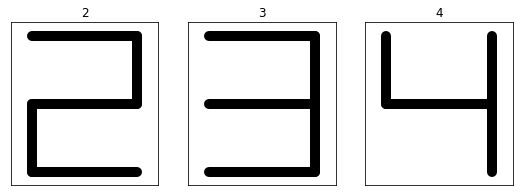

In [10]:
D = led_dataset(labels = [2, 3, 4], samples = 1, noise = 0.0)
plot_led(D, cols = 3)

## 3.2 Learning

## 3.3 Overfitting

In [11]:
def entropy(df, label):
    return sum([-p * log(p) 
                for p in df[label].value_counts(normalize = True)])
    
    
def gain(groups, label):
    df = pd.concat(group[1] for group in groups)
    ig = entropy(df, label)
    ig -= sum((len(group[1]) / len(df)) * entropy(group[1], label) 
              for group in groups)
    return ig


def train(df, label = 'y', nmin = 1):
        
    if len(df) <= nmin or len(df[label].value_counts()) == 1:
        return {'label' : df[label].value_counts().idxmax()}
            
    splits = []
    for feature in set(df.columns).difference(set([label])):
        
        if df[feature].dtype == float:
            vals = sorted(df[feature].unique())
            for t in [(a + b) / 2 for a, b in zip(vals, vals[1:])]:
                groups = df.groupby(by = (df[feature] <= t))
                splits.append({'groups':groups, 'feature':feature, 
                               'threshold':t, 'gain':gain(groups, label)})
                
        else:
            groups = df.groupby(by = df[feature])
            splits.append({'groups':groups, 'feature':feature, 
                           'threshold':None, 'gain':gain(groups, label)})
           
    tree = sorted(splits, reverse = True, 
                  key = lambda split: split['gain'])[0]
    if tree['gain'] == 0:
        return {'label' : df[label].value_counts().idxmax()}
    
    tree['children'] = {group[0]:train(group[1], label, nmin) 
                        for group in tree['groups']}
    
    return tree


def test(tree, x):
    if isinstance(x, pd.DataFrame):
        return [test(tree, row) for _, row in x.iterrows()]
    
    if 'label' in tree:
        return tree['label']
    
    val = x[tree['feature']]
    if 'threshold' in tree:
        val = val <= tree['threshold']
        
    return test(tree['children'][val], x)



def prune(tree, df, label = 'y'):
    
    if 'label' in tree:
        return tree
    
    if 'threshold' in tree:
        groups = df.groupby(by = (df[tree['feature']] < tree['threshold']))
    else:
        groups = df.groupby(by = df[tree['feature']])
        
    tree['children'] = {group[0]:prune(tree['children'][group[0]], group[1], label = label) for group in groups}
    
    leaf_errors = len(df) - max(df[label].value_counts())
    tree_errors = sum(y != yhat for y, yhat in zip(df[label], test(tree, df)))
    if leaf_errors <= tree_errors:
        return {'label' : df[label].value_counts().idxmax()}
    
    return tree

In [12]:
df = led_dataset(labels = [2, 3, 4], noise = 0.1, samples = 100)

In [13]:
tree = train(df, nmin = 20)

In [14]:
tree

{'children': {'off': {'children': {'off': {'children': {'off': {'label': 3},
      'on': {'children': {'off': {'label': 4},
        'on': {'children': {'off': {'label': 3},
          'on': {'children': {'off': {'label': 3},
            'on': {'children': {'off': {'label': 3}, 'on': {'label': 3}},
             'feature': 'top',
             'gain': 0.0018170557845632734,
             'groups': <pandas.core.groupby.groupby.DataFrameGroupBy object at 0x114a25860>,
             'threshold': None}},
           'feature': 'middle',
           'gain': 0.0022477268066988937,
           'groups': <pandas.core.groupby.groupby.DataFrameGroupBy object at 0x114a256a0>,
           'threshold': None}},
         'feature': 'top_right',
         'gain': 0.0024088045277340236,
         'groups': <pandas.core.groupby.groupby.DataFrameGroupBy object at 0x11499c780>,
         'threshold': None}},
       'feature': 'bottom',
       'gain': 0.15157705172180522,
       'groups': <pandas.core.groupby.groupby.D

In [15]:
df = pd.read_csv('iris.csv')

In [16]:
tree = train(df, label = 'species')

In [17]:
prune(tree, df, 'species')

{'children': {False: {'children': {False: {'children': {False: {'label': 'virginica'},
      True: {'children': {False: {'label': 'versicolor'},
        True: {'label': 'virginica'}},
       'feature': 'sepal_width',
       'gain': 0.6365141682948128,
       'groups': <pandas.core.groupby.groupby.DataFrameGroupBy object at 0x114abd160>,
       'threshold': 3.1}},
     'feature': 'petal_length',
     'gain': 0.06322064552064222,
     'groups': <pandas.core.groupby.groupby.DataFrameGroupBy object at 0x114ab4898>,
     'threshold': 4.85},
    True: {'children': {False: {'children': {False: {'children': {False: {'label': 'virginica'},
          True: {'label': 'versicolor'}},
         'feature': 'sepal_length',
         'gain': 0.6365141682948128,
         'groups': <pandas.core.groupby.groupby.DataFrameGroupBy object at 0x114ac8a58>,
         'threshold': 6.95},
        True: {'label': 'virginica'}},
       'feature': 'petal_width',
       'gain': 0.3182570841474064,
       'groups': <pan

In [28]:
def tree_plot(tree, graph = None, parent_id = None, edge_label = ''):
    
    if not graph:
        graph = graphviz.Digraph()
        graph.graph_attr['next_id'] = '0'
     
    if 'label' in tree:
        text = tree['label']
    else:
        text = tree['feature']
        if 'threshold' in tree and tree['threshold'] is not None:
            text += ' <= ' + str(tree['threshold'])
    
    this_id = graph.graph_attr['next_id']
    graph.node(str(this_id), str(text))
    graph.graph_attr['next_id'] = str(int(graph.graph_attr['next_id']) + 1)
    
    if parent_id:
        graph.edge(parent_id, this_id, label = ' ' + edge_label + ' ')
      
    if 'children' in tree:
        for child in tree['children']:
            tree_plot(tree['children'][child], graph, this_id, child)
    
    return graph
    

In [29]:
x = tree_plot(tree)

TypeError: Can't convert 'bool' object to str implicitly

In [ ]:
x.view()

In [30]:
D = led_dataset(labels = [2, 3, 4], samples = 10, noise = 0)

In [31]:
tree = train(D)

In [32]:
x = tree_plot(tree)

In [33]:
x.view()

'Digraph.gv.pdf'

In [ ]:
D

<sup>1</sup> Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

